In [ ]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Colab/255/TermProject/competitive-data-science-predict-future-sales.zip -d mydata

Archive:  /content/drive/MyDrive/Colab/255/TermProject/competitive-data-science-predict-future-sales.zip
replace mydata/item_categories.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mydata/item_categories.csv  
  inflating: mydata/items.csv        
  inflating: mydata/sales_train.csv  
  inflating: mydata/sample_submission.csv  
  inflating: mydata/shops.csv        
  inflating: mydata/test.csv         


In [ ]:
#loading data 
test = pd.read_csv('/content/mydata/test.csv', dtype={'ID': 'int32', 'shop_id': 'int8', 
                                                  'item_id': 'int16'})
cats = pd.read_csv('/content/mydata/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int16'})
items = pd.read_csv('/content/mydata/items.csv', dtype={'item_name': 'str', 'item_id': 'int16', 
                                                 'item_category_id': 'int16'})
shops = pd.read_csv('/content/mydata/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int8'})
sales = pd.read_csv('/content/mydata/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

Data Cleaning start

In [ ]:
print(cats.shape)
cats.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
# Checking for missing values in Item category data 

In [ ]:
cats.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [ ]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
# Checking for missing values in items
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [ ]:
print(sales.shape)
sales.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1
1,2013-03-01,0,25,2552,899.00,1
2,2013-05-01,0,25,2552,899.00,-1
3,2013-06-01,0,25,2554,1709.05,1
4,2013-01-15,0,25,2555,1099.00,1


In [ ]:
# Checking for missing values in sales.
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [ ]:
print(shops.shape)
shops.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
# Checking for null data in shops.
shops.isnull().sum() 

shop_name    0
shop_id      0
dtype: int64

In [ ]:
print('Min date from sales data set: %s' % sales['date'].min().date())
print('Max date from sales data set: %s' % sales['date'].max().date())

Min date from sales data set: 2013-01-01
Max date from sales data set: 2015-12-10


In [ ]:
#Adding year and month in sales
sales['year'] = sales['date_block_num'].apply(lambda x: ((x//12) + 2013))
sales['month'] = sales['date_block_num'].apply(lambda x: (x % 12))

In [ ]:
#Adding revenue 
sales['revenue'] = sales['item_price'] *  sales['item_cnt_day']

In [ ]:
#outliers

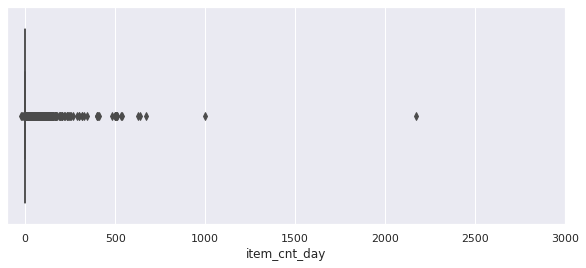

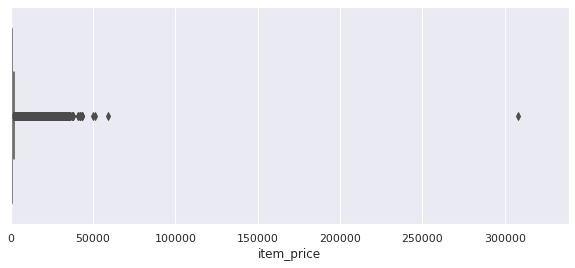

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.1)
sns.boxplot(x=sales.item_price)

In [ ]:
#Filtering based on outliers.
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<1001]

In [ ]:
#Remove negative values

In [ ]:
median = sales[(sales.shop_id==32)&(sales.item_id==2973)&(sales.date_block_num==4)&(sales.item_price>0)].item_price.median()
sales.loc[sales.item_price<0, 'item_price'] = median

In [ ]:
#Checking duplicate shop names by manual inspection.
shops[shops["shop_id"].isin([10, 11])]

,shop_name,shop_id
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


In [ ]:
#Fixing the sales data by removing the duplicate data after manually inspecting the data.
sales.loc[sales.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
sales.loc[sales.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
sales.loc[sales.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11
sales.loc[sales.shop_id == 23, 'shop_id'] = 24
test.loc[test.shop_id == 23, 'shop_id'] = 24

Data Analysis Start

In [ ]:
#Join data sets
edaSale  = sales.copy() 
edaItem = items.copy()
edaShops = shops.copy()
edaCat = cats.copy()

edaData = edaSale.join(edaItem, on='item_id', rsuffix='_').join(edaShops, on='shop_id', rsuffix='_').join(edaCat, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1) 

In [ ]:
# Select only useful features.
edaData_monthly = edaData[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [ ]:
# Group by month in this case "date_block_num" and aggregate features.
edaData_monthly = edaData_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
edaData_monthly = edaData_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features for EDA of the data 
edaData_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [ ]:
# Extract time based features.
edaData_monthly['year'] = edaData_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
edaData_monthly['month'] = edaData_monthly['date_block_num'].apply(lambda x: (x % 12))

In [ ]:
# Grouping data for EDA.
gp_month_mean = edaData_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = edaData_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = edaData_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = edaData_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = edaData_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = edaData_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

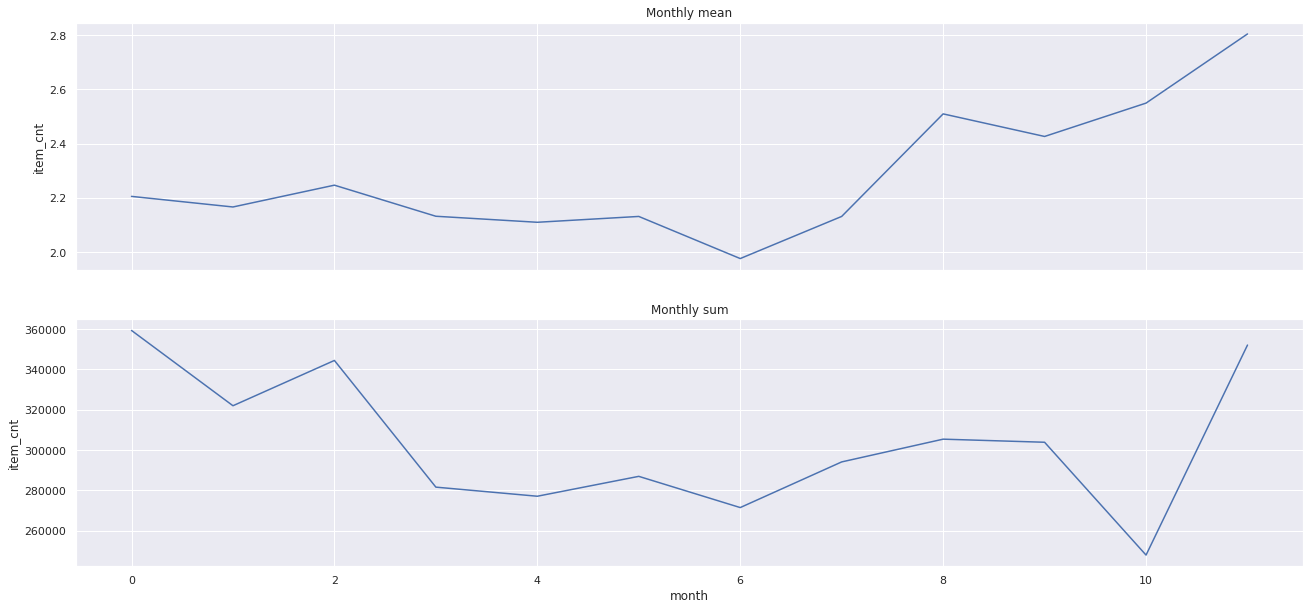

In [ ]:
#Check sales along the year
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

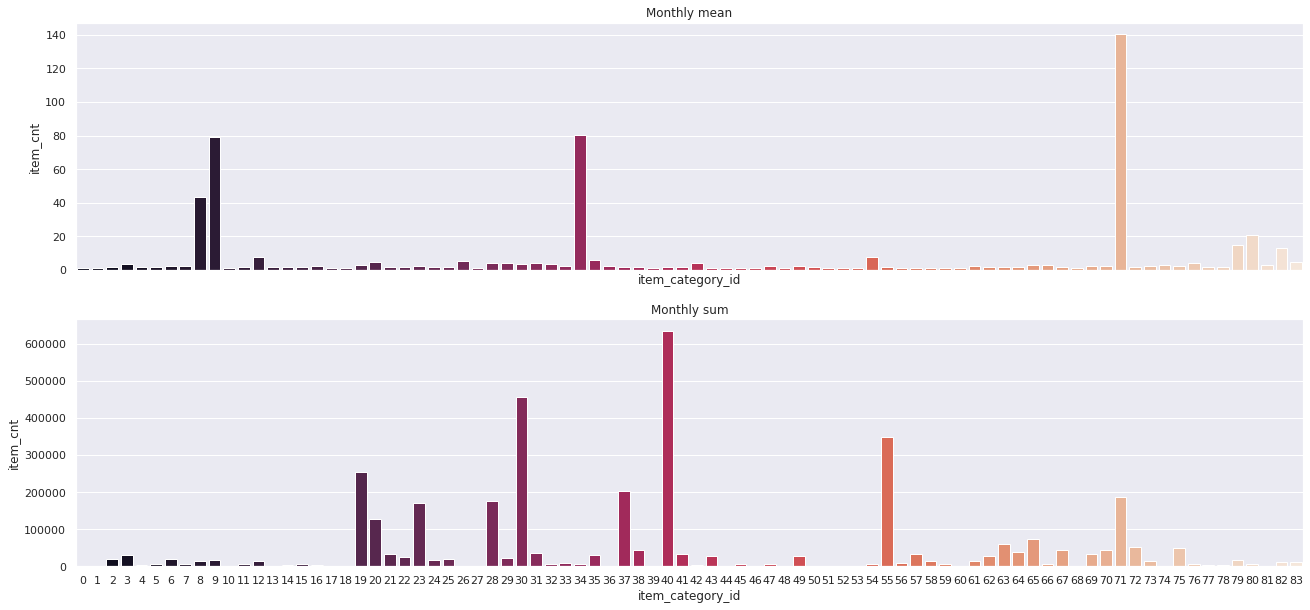

In [ ]:
#Check categories of sales along the year
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

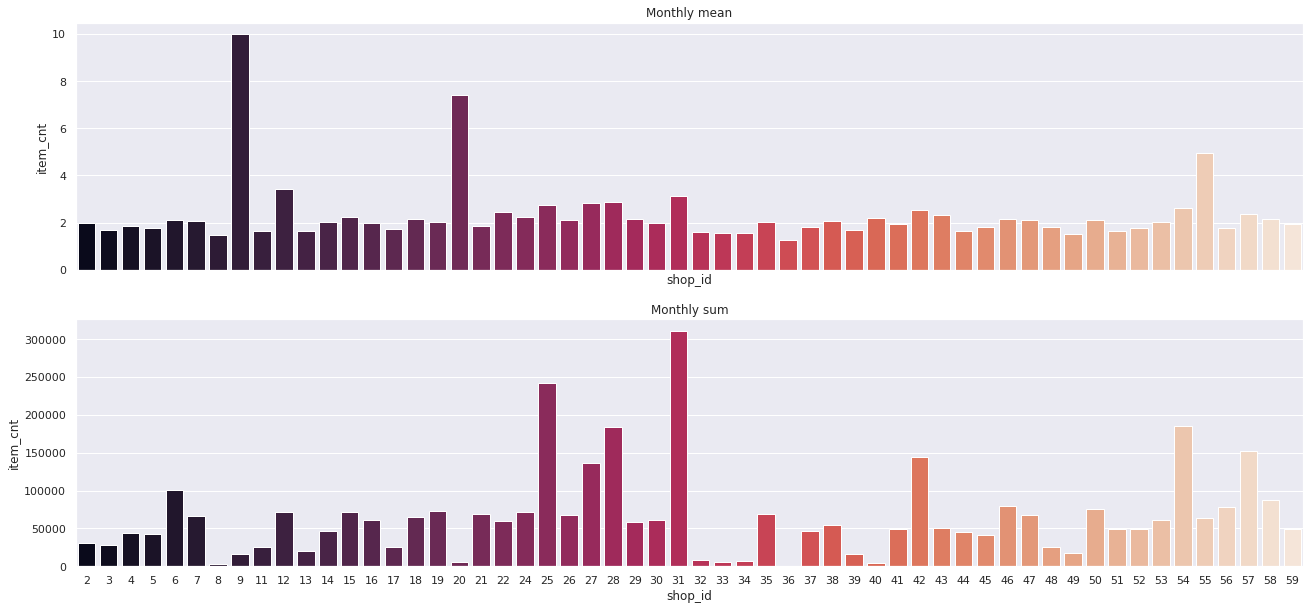

In [ ]:
#Checking Shop sales
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show() 

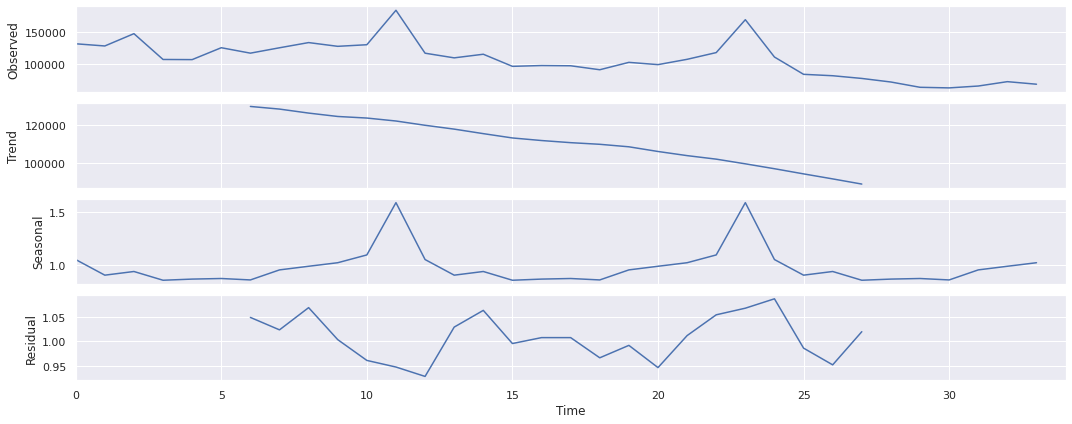

In [ ]:
#Decomposing data for trend
import statsmodels.api as sm
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()


Feature Extraction and Engineering

In [ ]:
#Adding city code and type code

In [ ]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [ ]:
#Creating matrix for data preprocessing
from itertools import product
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales_info = sales[sales.date_block_num==i]
    matrix.append(np.array(list(product([i], sales_info.shop_id.unique(), sales_info.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix.sort_values(cols,inplace=True)

In [ ]:
#Calculating monthly sales for each shop and item Id
group = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

In [ ]:
#Adding new column to the matrix
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

In [ ]:
#test set
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)


In [ ]:
#Merging test with sales in order to genearate new features for all of them.
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month


In [ ]:
#Feature Extraction - Merging city_code, item_category_id, type code and subtype_code to main matrix
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [ ]:
#Adding lag feature for the target.
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [ ]:
#Adding lag to add item_cnt-month for last one month, last two month, quaterly, half yearly and annually.
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

In [ ]:
#Printing the matrix to check newly added columns.
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.00,0.00,0,40,11,4,nan,nan,nan,nan,nan
1,0,2,27,1.00,0.00,0,19,5,10,nan,nan,nan,nan,nan
2,0,2,28,0.00,0.00,0,30,8,55,nan,nan,nan,nan,nan
3,0,2,29,0.00,0.00,0,23,5,16,nan,nan,nan,nan,nan
4,0,2,32,0.00,0.00,0,40,11,4,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11095269,34,45,18454,0.00,214195.00,20,55,13,2,1.00,0.00,0.00,0.00,nan
11095270,34,45,16188,0.00,214196.00,20,64,14,42,0.00,0.00,nan,nan,nan
11095271,34,45,15757,0.00,214197.00,20,55,13,2,0.00,0.00,0.00,0.00,0.00
11095272,34,45,19648,0.00,214198.00,20,40,11,4,0.00,0.00,0.00,0.00,nan


In [ ]:
#Feature Engineering : Adding Mean Encoding Feature for Month and item_cnt_cnt. .i.e. date_avg_item_cnt
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
#Feature Engineering : Adding Mean Encoding Feature for Month, itemid and item_cnt_cnt. .i.e. date_item_avg_item_cnt
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')#
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
#Feature Engineering : Adding Mean Encoding Feature for Month, shopid  and item_cnt_cnt. .i.e. date_shop_avg_item_cnt
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
#Mean Encoding Feature - Month, category and item_cnt_cnt
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
#Feature Engineering : Adding Mean Encoding Feature for Month, item_category_id  and item_cnt_cnt. .i.e. date_shop_cat_avg_item_cnt
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
#Feature Engineering : Adding Mean Encoding Feature for  Month, City and item_cnt_cnt. .i.e. date_city_avg_item_cnt
#Mean Encoding Feature -  Month and City
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
#Mean Encoding Feature - Adding Mean Encoding Feature for  Month, itemid, City and item_cnt_cnt. .i.e. date_item_city_avg_item_cnt
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
#Mean Encoding Feature - Adding Mean Encoding Feature for itemid and item price. .i.e. item_avg_item_price
group = sales.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

In [ ]:
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

In [ ]:
#Mean Encoding Feature - Adding Mean Encoding Feature for month, itemid and item price. .i.e. item_avg_item_price
group = sales.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

In [ ]:
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

In [ ]:
#Adding lag feature for date_item_avg_item_price
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

In [ ]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6
0,0,2,19,0.00,0.00,0,40,11,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,28.00,28.00,nan,nan,nan,nan,nan,nan
1,0,2,27,1.00,0.00,0,19,5,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1461.00,2324.00,nan,nan,nan,nan,nan,nan
2,0,2,28,0.00,0.00,0,30,8,55,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,310.00,549.00,nan,nan,nan,nan,nan,nan
3,0,2,29,0.00,0.00,0,23,5,16,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1759.00,2398.00,nan,nan,nan,nan,nan,nan
4,0,2,32,0.00,0.00,0,40,11,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,249.62,338.00,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11095269,34,45,18454,0.00,214195.00,20,55,13,2,1.00,0.00,0.00,0.00,nan,0.26,0.05,0.02,0.07,0.59,nan,0.13,0.13,0.14,0.14,nan,0.20,0.13,0.14,0.50,188.62,nan,99.00,99.00,99.00,99.00,98.94,199.00
11095270,34,45,16188,0.00,214196.00,20,64,14,42,0.00,0.00,nan,nan,nan,0.26,0.02,0.07,nan,nan,nan,0.13,0.13,nan,nan,nan,0.16,0.09,0.14,0.00,1257.00,nan,1359.00,1223.00,nan,nan,nan,nan
11095271,34,45,15757,0.00,214197.00,20,55,13,2,0.00,0.00,0.00,0.00,0.00,0.26,0.11,0.07,0.10,0.25,0.18,0.13,0.13,0.14,0.14,0.18,0.20,0.13,0.14,0.00,198.12,nan,229.00,229.00,229.00,229.00,229.00,208.12
11095272,34,45,19648,0.00,214198.00,20,40,11,4,0.00,0.00,0.00,0.00,nan,0.26,0.05,0.07,0.17,0.09,nan,0.13,0.13,0.14,0.14,nan,0.22,0.08,0.14,0.00,98.12,nan,89.12,99.00,94.88,99.00,99.00,99.00


In [ ]:
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']


In [ ]:
#Extracting trends
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [ ]:
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

In [ ]:
#Dropping the price feature after the trend.
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [ ]:
#Mean Encoding Feature - Adding Mean Encoding Feature for month, shopid and revenue. .i.e. item_avg_item_price
group = sales.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

In [ ]:
#Mean Encoding Feature - Adding Mean Encoding Feature for  shopid and date_shop_revenue. .i.e. item_avg_item_price
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

In [ ]:
matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

In [ ]:
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

In [ ]:
matrix = lag_feature(matrix, [1], 'delta_revenue')
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [ ]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,2,19,0.00,0.00,0,40,11,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan
1,0,2,27,1.00,0.00,0,19,5,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan
2,0,2,28,0.00,0.00,0,30,8,55,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan
3,0,2,29,0.00,0.00,0,23,5,16,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan
4,0,2,32,0.00,0.00,0,40,11,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11095269,34,45,18454,0.00,214195.00,20,55,13,2,1.00,0.00,0.00,0.00,nan,0.26,0.05,0.02,0.07,0.59,nan,0.13,0.13,0.14,0.14,nan,0.20,0.13,0.14,0.50,-0.48,-0.29
11095270,34,45,16188,0.00,214196.00,20,64,14,42,0.00,0.00,nan,nan,nan,0.26,0.02,0.07,nan,nan,nan,0.13,0.13,nan,nan,nan,0.16,0.09,0.14,0.00,0.08,-0.29
11095271,34,45,15757,0.00,214197.00,20,55,13,2,0.00,0.00,0.00,0.00,0.00,0.26,0.11,0.07,0.10,0.25,0.18,0.13,0.13,0.14,0.14,0.18,0.20,0.13,0.14,0.00,0.16,-0.29
11095272,34,45,19648,0.00,214198.00,20,40,11,4,0.00,0.00,0.00,0.00,nan,0.26,0.05,0.07,0.17,0.09,nan,0.13,0.13,0.14,0.14,nan,0.22,0.08,0.14,0.00,-0.09,-0.29


In [ ]:
#Extracting the month feature
matrix['month'] = matrix['date_block_num'] % 12

In [ ]:
#Extracting the days feature
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [ ]:
#Extracting the item_shop_last_sale feature
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num  

In [ ]:
#Extracting the item_last_sale feature
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num       

In [ ]:
#Extracting the item_first_sale feature
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [ ]:
#removing 1st 12 months
matrix = matrix[matrix.date_block_num > 11]

In [ ]:
#Adding null
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

Model Training Start

In [ ]:
#Setting the data for the Model training.
data = matrix[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [ ]:
#Spliting the Train, validation and test
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
del data

In [ ]:
#XGBoost Regressor Model Implementation.

In [ ]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[05:13:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:13:29] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15123	validation_1-rmse:1.11693
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10717	validation_1-rmse:1.08397
[2]	validation_0-rmse:1.06633	validation_1-rmse:1.05305
[3]	validation_0-rmse:1.03158	validation_1-rmse:1.02736
[4]	validation_0-rmse:1.00475	validation_1-rmse:1.00853
[5]	validation_0-rmse:0.979663	validation_1-rmse:0.990091
[6]	validation_0-rmse:0.958649	validation_1-rmse:0.975133
[7]	validation_0-rmse:0.939311	validation_1-rmse:0.961287
[8]	validation_0-rmse:0.92413	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [ ]:
#predicting the sale forcast from training, validation and testing data. 
#Clipping the prediction count from 0-20 
Y_train_pred = model.predict(X_train).clip(0, 20)
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

In [ ]:
#Generating submission  csv for the XGBoost model
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission1.csv', index=False)


In [ ]:
#Getting RMSE score for XGboost
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, Y_pred)))

Train rmse: 0.82488465
Validation rmse: 0.9061621


In [ ]:
#Getting RMSLE score
print('Training rmsle:', np.sqrt(mean_squared_log_error(Y_valid, Y_pred)))
print('Validation rmsle:', np.sqrt(mean_squared_log_error(Y_valid, Y_pred)))

Training rmsle: 0.30314052
Validation rmsle: 0.30314052


In [ ]:
#Getting MAE score
print('Train mae:', mean_absolute_error(Y_train, Y_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, Y_pred))

Train mae: 0.3116245
Validation mae: 0.3158552


In [ ]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg",height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

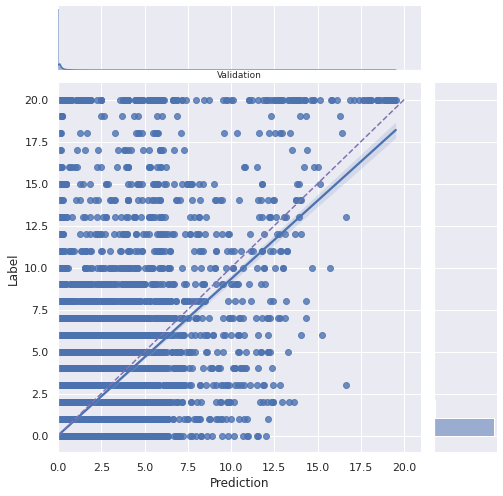

In [ ]:
#plotting the projected values by the model and the true values.
model_performance_sc_plot(Y_pred, Y_valid, 'Validation')

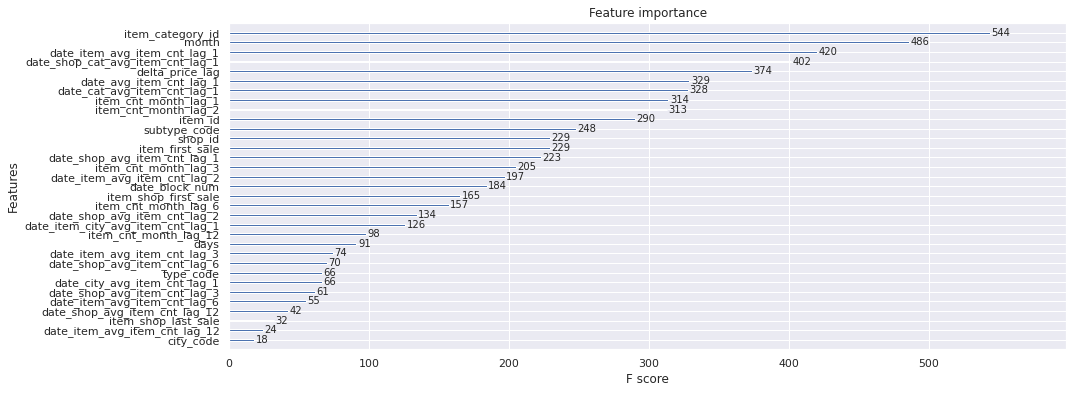

In [ ]:
#Checking the importance of the features.
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(model)
plt.show()

In [ ]:
#Random Forest Model Implementation.

In [ ]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
#predicting the sale forcast from training, validation and testing data. 
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_valid)
rf_test_pred = rf_model.predict(X_test)

In [ ]:
#Getting RMSE score for Random Forest
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, rf_val_pred)))

Train rmse: 0.8762175802846264
Validation rmse: 0.9412465053955391


In [ ]:
#Getting RMSLE score
print('Training rmsle:', np.sqrt(mean_squared_log_error(Y_train, rf_train_pred)))
print('Validation rmsle:', np.sqrt(mean_squared_log_error(Y_valid, rf_val_pred)))

Training rmsle: 0.3042393764093474
Validation rmsle: 0.31314124967514506


In [ ]:
#Getting MAE score for Random Forest
print('Train mae:', mean_absolute_error(Y_train, rf_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, rf_val_pred))

Train mae: 0.3241911086508153
Validation mae: 0.31574528588596984


In [ ]:
#Getting submission csv for the RF model
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": rf_test_pred
})
submission.to_csv('rf_submission1.csv', index=False)


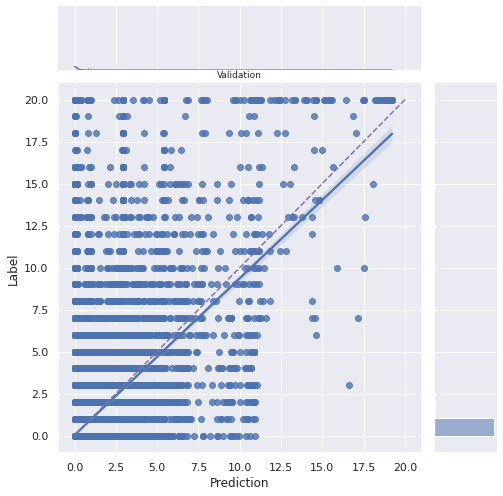

In [ ]:
#plotting the projected values by the model and the true values.
model_performance_sc_plot(rf_val_pred, Y_valid, 'Validation')

In [ ]:
#Linear Regression Model Implementation

In [ ]:
#Normalizing the data
lr_scaler = MinMaxScaler()
lr_scaler.fit(X_train)
lr_train = lr_scaler.transform(X_train)
lr_val = lr_scaler.transform(X_valid)
lr_test = lr_scaler.transform(X_test)

In [ ]:
#trainoing the model
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [ ]:
#predicting the sale forcast from training, validation and testing data. 
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [ ]:
#Getting RMSE score for Linear Regression
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lr_val_pred)))

Train rmse: 0.9168681
Validation rmse: 0.9635804


In [ ]:
#Getting MAE score for Linear Regression
print('Train mae:', mean_absolute_error(Y_train, lr_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, lr_val_pred))

Train mae: 0.34837243
Validation mae: 0.36626872


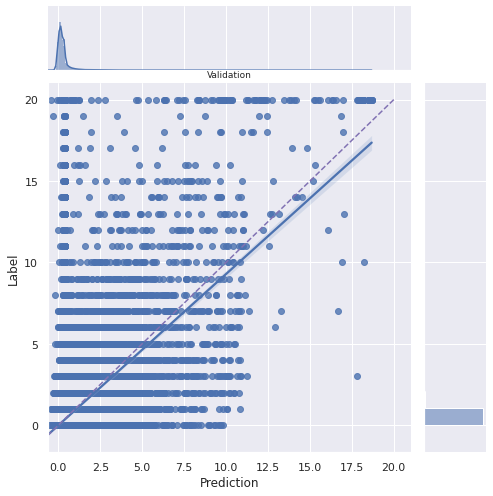

In [ ]:
#plotting the projected values by the model and the true values.
model_performance_sc_plot(lr_val_pred, Y_valid, 'Validation')

In [ ]:
#Getting submission csv for the LR model
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": lr_test_pred
})
submission.to_csv('lr_submission1.csv', index=False)

In [ ]:
#KNN model Implemetation

In [ ]:
#Subsampling the data from KNN model
X_train_sampled = X_train[:500000]
Y_train_sampled = Y_train[:500000]

knn_train = X_train_sampled
knn_val = X_valid
knn_test = X_test

In [ ]:
#Normalizing the data 
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [ ]:
#Training the KNN model
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                    weights='uniform')

In [ ]:
#predicting the sale forcast from training, validation and testing data. 
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [ ]:
#Getting RMSE score for KNN
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, knn_val_pred)))

Train rmse: 0.6875
Validation rmse: 1.006


In [ ]:
#Getting RMSLE score for KNN
print('Training rmsle:', np.sqrt(mean_squared_log_error(Y_train_sampled, knn_train_pred)))
print('Validation rmsle:', np.sqrt(mean_squared_log_error(Y_valid, knn_val_pred)))

Training rmsle: 0.2546
Validation rmsle: 0.346


In [ ]:
#Getting MAE score for KNN
print('Train mae:', mean_absolute_error(Y_train_sampled, knn_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid, knn_val_pred))

Train mae: 0.256
Validation mae: 0.3267


In [ ]:
#Getting submission csv for the KNN model
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": knn_test_pred
})
submission.to_csv('knn_submission1.csv', index=False)

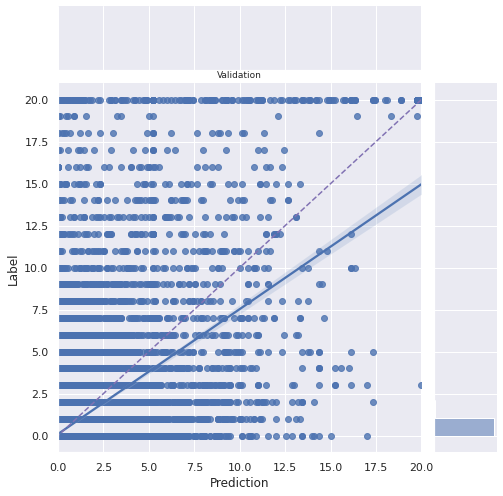

In [ ]:
#plotting the projected values by the model and the true values.
model_performance_sc_plot(knn_val_pred, Y_valid, 'Validation')

In [ ]:
f#LSTM model Implementation

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout

In [ ]:
#Reshaping the Data for LSTM Model
X_train1=X_train.values.reshape((X_train.shape[0],X_train.shape[1],1))
X_valid1=X_valid.values.reshape((X_valid.shape[0],X_valid.shape[1],1))

Y_train1=Y_train.values.reshape((Y_train.shape[0],1))
Y_valid1=Y_valid.values.reshape((Y_valid.shape[0],1))

X_test1=X_test.values.reshape((X_test.shape[0],X_test.shape[1],1))

In [ ]:
#Buidling the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(X_train1.shape[1], X_train1.shape[2]),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(8))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 34, 16)            1152      
_________________________________________________________________
dropout (Dropout)            (None, 34, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 7,697
Trainable params: 7,697
Non-trainable params: 0
______________________________________________________

Epoch 1/10
3021/3021 [==============================] - 25s 8ms/step - loss: 0.9336 - mse: 0.9336 - val_loss: 0.9268 - val_mse: 0.9268
Epoch 2/10
3021/3021 [==============================] - 24s 8ms/step - loss: 0.8750 - mse: 0.8750 - val_loss: 0.9138 - val_mse: 0.9138
Epoch 3/10
3021/3021 [==============================] - 24s 8ms/step - loss: 0.8561 - mse: 0.8561 - val_loss: 0.9311 - val_mse: 0.9311
Epoch 4/10
3021/3021 [==============================] - 25s 8ms/step - loss: 0.8413 - mse: 0.8413 - val_loss: 0.9164 - val_mse: 0.9164
Epoch 5/10
3021/3021 [==============================] - 24s 8ms/step - loss: 0.8292 - mse: 0.8292 - val_loss: 0.8798 - val_mse: 0.8798
Epoch 6/10
3021/3021 [==============================] - 24s 8ms/step - loss: 0.8227 - mse: 0.8227 - val_loss: 0.8739 - val_mse: 0.8739
Epoch 7/10
3021/3021 [==============================] - 24s 8ms/step - loss: 0.8181 - mse: 0.8181 - val_loss: 0.8796 - val_mse: 0.8796
Epoch 8/10
3021/3021 [==============================] -

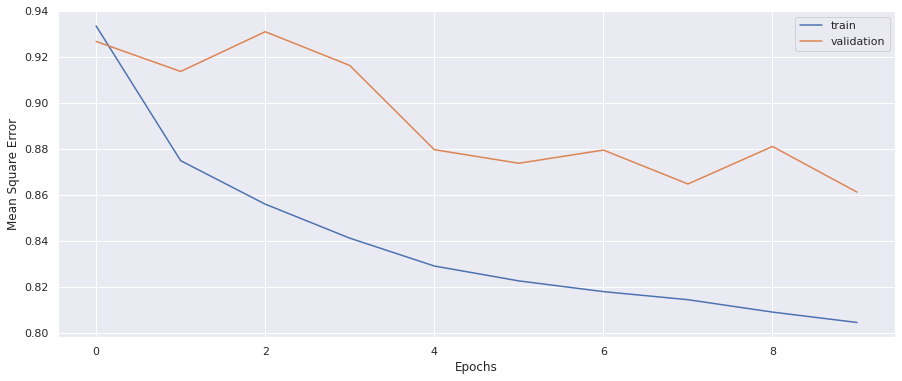

<Figure size 1080x432 with 0 Axes>

In [ ]:
#Training the LSTM model
from keras.callbacks import EarlyStopping
LSTM_PARAM = {"batch_size":2048,
              "verbose":1,
              "epochs":10}

    
callbacks_list=[EarlyStopping(monitor="val_loss",min_delta=.001, patience=3,mode='auto')]
hist = model_lstm.fit(X_train1, Y_train1,validation_data=(X_valid1, Y_valid1),callbacks=callbacks_list, **LSTM_PARAM)
lstm_prediction = model_lstm.predict(X_test1)

# Model Evaluation
best = np.argmin(hist.history["val_loss"])
print("Optimal Epoch: {}",best)
print("Train Score: {}, Validation Score: {}".format(hist.history["loss"][best],hist.history["val_loss"][best]))

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()
plt.savefig("Train and Validation MSE Progression.png")

In [ ]:
#predicting the sale forcast from training, validation and testing data. 
lstm_valid_pred = model_lstm.predict(X_valid1)
lstm_train_pred = model_lstm.predict(X_train1)
lstm_test_pred = model_lstm.predict(X_test1)

In [ ]:
#Getting RMSE score for LSTM model
print('Train rmse:', np.sqrt(mean_squared_error(Y_train1, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid1, lstm_valid_pred)))

Train rmse: 0.8783299
Validation rmse: 0.92807496


In [ ]:
#Getting MAE score for LSTM model
print('Train mae:', mean_absolute_error(Y_train1, lstm_train_pred))
print('Validation mae:', mean_absolute_error(Y_valid1, lstm_valid_pred))

Train mae: 0.3138391
Validation mae: 0.30625278


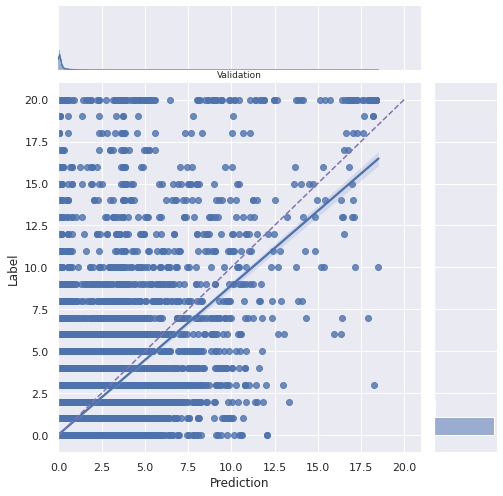

In [ ]:
#plotting the projected values by the model and the true values.
model_performance_sc_plot(lstm_valid_pred, Y_valid, 'Validation')

In [ ]:
#Generating submission csv for kaggle
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": knn_test_pred
})
submission.to_csv('lstm_test_pred.csv', index=False)

In [ ]:
#Trying Ensemble method for regression

In [ ]:
#building the first model based on the validation predictions of the all the models
first_level_validation = pd.DataFrame(Y_pred, columns=['xgbm'])
first_level_validation['lstm'] = lstm_valid_pred
first_level_validation['random_forest'] = rf_val_pred
first_level_validation['linear_regression'] = lr_val_pred
first_level_validation['knn'] = knn_val_pred
first_level_validation.head(20)

,xgbm,lstm,random_forest,linear_regression,knn
0,0.05,0.03,0.08,-0.14,0.00
1,0.12,0.02,0.22,-0.20,0.22
2,0.24,0.30,0.07,0.09,0.00
3,0.26,0.25,0.22,0.38,0.11
4,0.03,-0.00,0.02,0.04,0.00
5,0.03,0.00,0.02,-0.04,0.00
6,0.03,0.00,0.02,-0.07,0.00
7,0.02,0.01,0.02,-0.08,0.00
8,0.02,0.01,0.02,-0.09,0.00
9,0.05,0.01,0.08,-0.11,0.00


In [ ]:
#building the first model based on thetest predictions of the all the models
first_level_test = pd.DataFrame(Y_test, columns=['xgbm'])
first_level_test['lstm'] = lstm_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,xgbm,lstm,random_forest,linear_regression,knn
0,0.69,0.78,0.37,0.48,1.00
1,0.35,0.22,0.57,0.37,0.33
2,1.19,1.35,0.71,1.15,1.56
3,0.52,0.14,0.53,0.30,0.00
4,3.86,2.05,2.92,0.40,0.00


In [ ]:
#adding the LR as second level
meta_model = LinearRegression(n_jobs=-1)

In [ ]:
#first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level_validation, Y_valid)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [ ]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [ ]:
#Getting RMSE score for ensemble model
print('validation rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_valid)))

validation rmse: 0.9009060196964411


In [ ]:
#Getting MAE score for ensemble model
print('Validation mae:', mean_absolute_error(ensemble_pred, Y_valid))

Validation mae: 0.31215250028903135


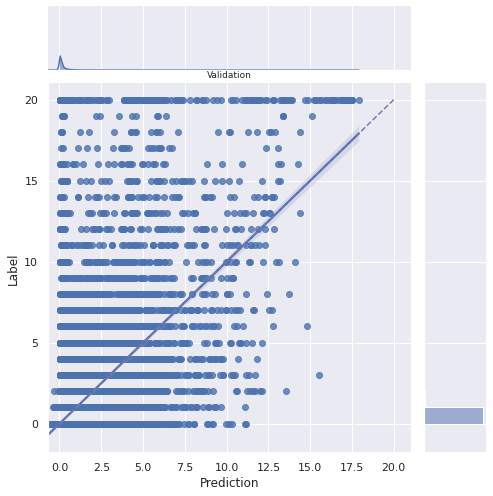

In [ ]:
#plotting the projected values by the model and the true values.
model_performance_sc_plot(ensemble_pred, Y_valid, 'Validation')

In [ ]:
#Getting the submission Csv for the ensemble model.
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('ensemble_submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.79
1,1,0.22
2,2,1.32
3,3,0.37
4,4,3.36
5,5,0.80
6,6,0.91
7,7,0.11
8,8,1.00
9,9,0.54
